# CNN

Convolutional Neural Network - A deep learning architechture that is primarily used for image recognition and analysis tasks. Currently one of the most popular model amongst image classification problems nowadays.

A CNN typically consists of multiple layers of specialized neurons that perform different tasks, including convolutional layers, pooling layers, and fully connected layers, that change the size and dimensions of the data along the process, in order to get the features out of an image and classify it into a single vector.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import random
import os
from tensorflow.keras import layers
%matplotlib inline

In [2]:
downscaling = 4

Conv2D, MaxPooling, Flatten and Dense are important building blocks in the CNN model.

Conv2D - performs convolution on the image, using a kernal or filter.

MaxPooling - this, as opposed to Conv2D, reduces the size of the features, by deviding the feature map by taking the maximum value in each region (the regions are devided by the value inserted into the MaxPooling layer)

Flatten - takes the output of a convolutional or pooling layer and converts it into a one-dimensional vector. This is necessary because the next layer in the network, which is typically a dense or fully connected layer, requires a one-dimensional input.

Dense (also known as a fully connected layer) - a type of layer in a neural network that performs classification or regression by taking the flattened input from the previous layer and computing a weighted sum of the inputs, followed by the application of an activation function.

In [3]:
cnn = tf.keras.models.Sequential()

cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(int(384/downscaling), int(512/downscaling), 3)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Flatten())

cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(6))

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 126, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 14, 64)       0

In [4]:
cnn.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [2]:
def generate_data(data_path, grayscale=False, downscale=None):
    cardboard, glass, metal, paper, plastic, trash = [], [], [], [], [], []
    for root, _, files in os.walk(data_path):
        for file in files:
            if ".jpg" in file:

                if grayscale:
                    img = cv2.cvtColor(cv2.imread(os.path.join(root, file)), cv2.COLOR_BGR2GRAY)
                else:
                    img = cv2.cvtColor(cv2.imread(os.path.join(root, file)), cv2.COLOR_BGR2RGB)
                
                if downscale:
                    new_size = (int(img.shape[1]/downscale), int(img.shape[0]/downscale))
                    img = cv2.resize(img, new_size)

                if "cardboard" in file: cardboard.append(img)
                elif "glass" in file: glass.append(img)
                elif "metal" in file: metal.append(img)
                elif "paper" in file: paper.append(img)
                elif "plastic" in file: plastic.append(img)
                elif "trash" in file: trash.append(img)
                else: print(f"Unable to classify image: {file}")
    images = {"cardboard": np.array(cardboard), "glass": np.array(glass), "metal": np.array(metal),
              "paper": np.array(paper), "plastic": np.array(plastic), "trash": np.array(trash)}
    return images

def label2vec(label):
    vec = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    vec[label] = 1.0
    return np.array(vec)

labels = {"cardboard": 0, "glass": 1, "metal": 2, "paper": 3, "plastic": 4, "trash": 5}

def train_test_split(images, train_size=0.8):
    train_data, test_data = [], []
    for key, value in images.items():
        data = value
        random.shuffle(data)
        split_size = int(len(data) * train_size)
        for img in data[:split_size]:
            train_data.append([img, labels[key]])
        for img in data[split_size:]:
            test_data.append([img, labels[key]])
    
    random.shuffle(train_data)
    random.shuffle(test_data)

    X_train = np.array([e[0] for e in train_data])
    y_train = np.array([label2vec(e[1]) for e in train_data])

    X_test = np.array([e[0] for e in test_data])
    y_test = np.array([label2vec(e[1]) for e in test_data])

    return X_train/255, y_train, X_test/255, y_test

In [6]:
def show_sample(X, y):
    fig = plt.figure(figsize=(10, 7))
    rows, columns = 1, 6
    for i in range(6):
        for j in range(len(X)):
            if y[j][i] == 1:
                fig.add_subplot(rows, columns, i+1)
                plt.imshow(X[j])
                plt.axis('off')
                plt.title(str(y[j]))
                break

Here, we translate the labels into vectors, where the index of the vector indicates the class.

In [7]:
original_images = generate_data("data", downscale=downscaling)
X_train, y_train, X_test, y_test = train_test_split(original_images, train_size=0.9)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_Test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (2271, 96, 128, 3)
y_train: (2271, 6)
X_Test: (256, 96, 128, 3)
y_test: (256, 6)


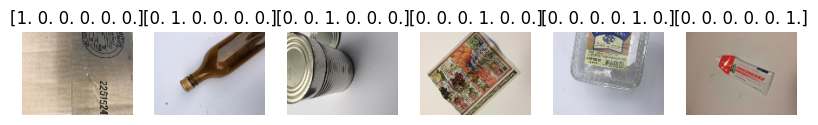

In [8]:
show_sample(X_train, y_train)

We will measure the amount of time training takes.

In [3]:
import time

In [10]:
start = time.time()

history = cnn.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

print(f"Time: {time.time() - start} seconds")

Epoch 1/10
71/71 [==============================] - 16s 211ms/step - loss: 0.1468 - accuracy: 0.2558 - val_loss: 0.1235 - val_accuracy: 0.3906
Epoch 2/10
71/71 [==============================] - 15s 204ms/step - loss: 0.1150 - accuracy: 0.4844 - val_loss: 0.1145 - val_accuracy: 0.4805
Epoch 3/10
71/71 [==============================] - 16s 225ms/step - loss: 0.0969 - accuracy: 0.6028 - val_loss: 0.1049 - val_accuracy: 0.5312
Epoch 4/10
71/71 [==============================] - 18s 254ms/step - loss: 0.0788 - accuracy: 0.7103 - val_loss: 0.1027 - val_accuracy: 0.5586
Epoch 5/10
71/71 [==============================] - 18s 254ms/step - loss: 0.0646 - accuracy: 0.8023 - val_loss: 0.0938 - val_accuracy: 0.6562
Epoch 6/10
71/71 [==============================] - 16s 227ms/step - loss: 0.0500 - accuracy: 0.8780 - val_loss: 0.0884 - val_accuracy: 0.6875
Epoch 7/10
71/71 [==============================] - 15s 215ms/step - loss: 0.0397 - accuracy: 0.9181 - val_loss: 0.0839 - val_accuracy: 0.6992

8/8 - 0s - loss: 0.0759 - accuracy: 0.7188 - 409ms/epoch - 51ms/step


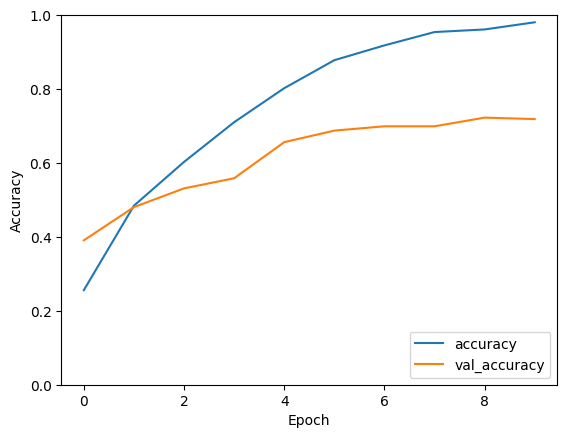

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = cnn.evaluate(X_test, y_test, verbose=2)

The testing score is pretty low.

This could be improved in a few ways. Let's adding more layers.

#### trying to add more layers

In [15]:
cnn_more_layers = tf.keras.models.Sequential()

cnn_more_layers.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(int(384/downscaling), int(512/downscaling), 3)))
cnn_more_layers.add(layers.MaxPooling2D((2, 2)))
cnn_more_layers.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_more_layers.add(layers.MaxPooling2D((2, 2)))
cnn_more_layers.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_more_layers.add(layers.MaxPooling2D((2, 2)))
cnn_more_layers.add(layers.Conv2D(256, (3, 3), activation='relu'))
cnn_more_layers.add(layers.MaxPooling2D((2, 2)))
cnn_more_layers.add(layers.Conv2D(256, (3, 3), activation='relu'))
cnn_more_layers.add(layers.MaxPooling2D((2, 2)))

cnn_more_layers.add(layers.Flatten())

cnn_more_layers.add(layers.Dense(256, activation='relu'))
cnn_more_layers.add(layers.Dense(6))

cnn_more_layers.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 94, 126, 32)       896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 47, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 61, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 22, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 20, 28, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 10, 14, 128)     

In [16]:
cnn_more_layers.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [17]:
start = time.time()

history_more_layers = cnn_more_layers.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

print(f"Time: {time.time() - start} seconds")

Epoch 1/10
71/71 [==============================] - 23s 302ms/step - loss: 0.1355 - accuracy: 0.2413 - val_loss: 0.1312 - val_accuracy: 0.3164
Epoch 2/10
71/71 [==============================] - 24s 339ms/step - loss: 0.1256 - accuracy: 0.3611 - val_loss: 0.1233 - val_accuracy: 0.3516
Epoch 3/10
71/71 [==============================] - 24s 338ms/step - loss: 0.1113 - accuracy: 0.4584 - val_loss: 0.1097 - val_accuracy: 0.4688
Epoch 4/10
71/71 [==============================] - 21s 297ms/step - loss: 0.0975 - accuracy: 0.5465 - val_loss: 0.1065 - val_accuracy: 0.5000
Epoch 5/10
71/71 [==============================] - 23s 329ms/step - loss: 0.0828 - accuracy: 0.6438 - val_loss: 0.1007 - val_accuracy: 0.5742
Epoch 6/10
71/71 [==============================] - 24s 341ms/step - loss: 0.0698 - accuracy: 0.7283 - val_loss: 0.1083 - val_accuracy: 0.5664
Epoch 7/10
71/71 [==============================] - 21s 297ms/step - loss: 0.0511 - accuracy: 0.8278 - val_loss: 0.0802 - val_accuracy: 0.6953

8/8 - 1s - loss: 0.0598 - accuracy: 0.7812 - 581ms/epoch - 73ms/step


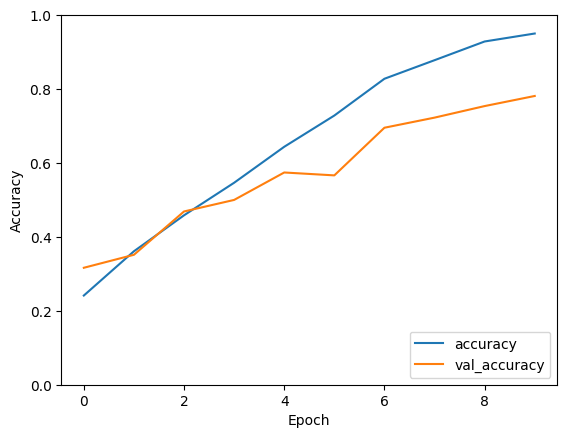

In [18]:
plt.plot(history_more_layers.history['accuracy'], label='accuracy')
plt.plot(history_more_layers.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss_more_layers, test_acc_more_layers = cnn_more_layers.evaluate(X_test, y_test, verbose=2)

Reaching an accuracy of 70%

#### Adding Normalization

To prevent overfittin, we increase the size of the data by adding the horizontal flip of each image, thus multiplying the amount of images by 2.

We then lower the amount of layers, and add normalization layers, those include Droupout and BatchNormalization.

In [4]:
def train_test_split(images, train_size=0.8, agument=False):
    train_data, test_data = [], []
    for key, value in images.items():
        data = value
        random.shuffle(data)
        split_size = int(len(data) * train_size)
        for img in data[:split_size]:
            train_data.append([img, labels[key]])
            if agument:
                train_data.append([cv2.flip(img, 0), labels[key]])
        for img in data[split_size:]:
            test_data.append([img, labels[key]])
            if agument:
                test_data.append([cv2.flip(img, 0), labels[key]])
    
    random.shuffle(train_data)
    random.shuffle(test_data)

    X_train = np.array([e[0] for e in train_data])
    y_train = np.array([label2vec(e[1]) for e in train_data])

    X_test = np.array([e[0] for e in test_data])
    y_test = np.array([label2vec(e[1]) for e in test_data])

    return X_train/255, y_train, X_test/255, y_test

In [5]:
normalization_downscaling = 4

normalization_images = generate_data("data", downscale=normalization_downscaling)
X_train, y_train, X_test, y_test = train_test_split(normalization_images, train_size=0.9, agument=True)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_Test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (4542, 96, 128, 3)
y_train: (4542, 6)
X_Test: (512, 96, 128, 3)
y_test: (512, 6)


Dropout - a regularization technique used to prevent overfitting. It works by randomly dropping out (setting to zero) some of the output values of a layer during training.

BatchNormalization - a technique used to improve the performance and stability of neural networks. It works by subtracting the mean and dividing by the standard deviation of the inputs in a mini-batch, thus normalizing the inputs to a layer.

In [6]:
cnn_normalization = tf.keras.models.Sequential()

cnn_normalization.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(int(384/normalization_downscaling), int(512/normalization_downscaling), 3)))
cnn_normalization.add(layers.MaxPooling2D((2, 2)))
cnn_normalization.add(layers.BatchNormalization())
cnn_normalization.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_normalization.add(layers.MaxPooling2D((2, 2)))
cnn_normalization.add(layers.BatchNormalization())
cnn_normalization.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_normalization.add(layers.MaxPooling2D((2, 2)))
cnn_normalization.add(layers.Dropout(0.25))

cnn_normalization.add(layers.Flatten())

cnn_normalization.add(layers.Dense(64, activation='relu'))
cnn_normalization.add(layers.BatchNormalization())
cnn_normalization.add(layers.Dropout(0.25))
cnn_normalization.add(layers.Dense(6, activation='softmax'))

cnn_normalization.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 126, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 63, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 47, 63, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 30, 64)       0         
 2D)                                                             
                                                        

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

cnn_normalization.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
start = time.time()

history_normalization = cnn_normalization.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

print(f"Time: {time.time() - start} seconds")

Epoch 1/10
142/142 [==============================] - 38s 246ms/step - loss: 1.5419 - accuracy: 0.4465 - val_loss: 1.8070 - val_accuracy: 0.2539
Epoch 2/10
142/142 [==============================] - 35s 246ms/step - loss: 1.0543 - accuracy: 0.6173 - val_loss: 1.7074 - val_accuracy: 0.3086
Epoch 3/10
142/142 [==============================] - 34s 240ms/step - loss: 0.8094 - accuracy: 0.7147 - val_loss: 1.2817 - val_accuracy: 0.4980
Epoch 4/10
142/142 [==============================] - 35s 245ms/step - loss: 0.6663 - accuracy: 0.7754 - val_loss: 1.0201 - val_accuracy: 0.6445
Epoch 5/10
142/142 [==============================] - 35s 244ms/step - loss: 0.5748 - accuracy: 0.8135 - val_loss: 0.8322 - val_accuracy: 0.7129
Epoch 6/10
142/142 [==============================] - 34s 239ms/step - loss: 0.4983 - accuracy: 0.8391 - val_loss: 0.7374 - val_accuracy: 0.7539
Epoch 7/10
142/142 [==============================] - 34s 240ms/step - loss: 0.4122 - accuracy: 0.8765 - val_loss: 0.6812 - val_ac

16/16 - 1s - loss: 0.6517 - accuracy: 0.8008 - 1s/epoch - 63ms/step


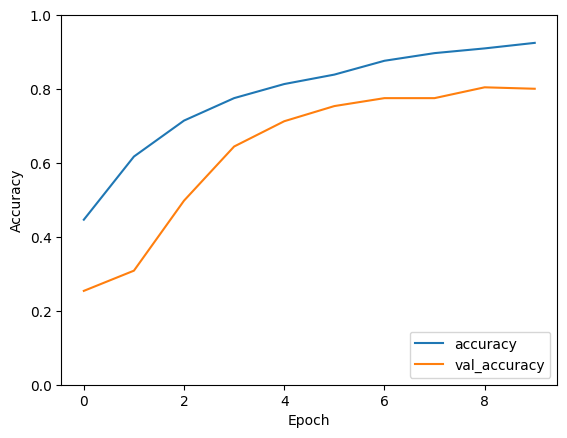

In [9]:
plt.plot(history_normalization.history['accuracy'], label='accuracy')
plt.plot(history_normalization.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss_normalization, test_acc_normalization = cnn_normalization.evaluate(X_test, y_test, verbose=2)

A very good training and testing score, in an even better time.

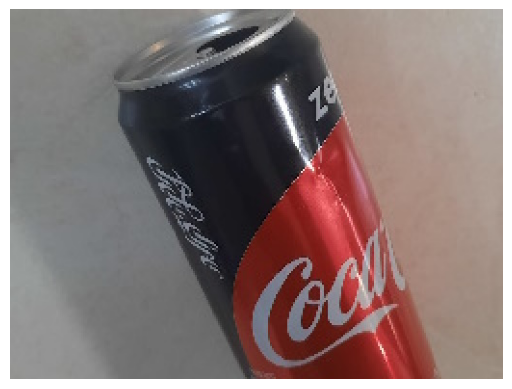

In [16]:
metal_test = cv2.cvtColor(cv2.imread("metal_test.jpg"), cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()
ax.imshow(metal_test)
ax.axis('off')
plt.show()

In [17]:
start = time.time()

metal_downscaled = cv2.resize(metal_test, (int(metal_test.shape[1]/normalization_downscaling), int(metal_test.shape[0]/normalization_downscaling)))
metal_downscaled = metal_downscaled/255
metal_prediction = cnn_normalization.predict(np.array([metal_downscaled]))[0]

print(f"Time: {time.time() - start} seconds")

print(list(labels.keys())[np.argmax(metal_prediction)], max(metal_prediction)/sum(metal_prediction))

1/1 [==============================] - 0s 28ms/step
Time: 0.07584834098815918 seconds
metal 0.9691034367028305


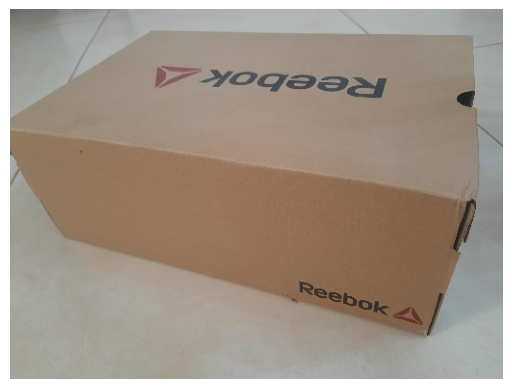

In [14]:
cardboard_test = cv2.cvtColor(cv2.imread("cardboard_test.jpg"), cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()
ax.imshow(cardboard_test)
ax.axis('off')
plt.show()

In [15]:
start = time.time()

cardboard_downscaled = cv2.resize(cardboard_test, (int(cardboard_test.shape[1]/normalization_downscaling), int(cardboard_test.shape[0]/normalization_downscaling)))
cardboard_downscaled = cardboard_downscaled/255
cardboard_prediction = cnn_normalization.predict(np.array([cardboard_downscaled]))[0]

print(f"Time: {time.time() - start} seconds")

for i, e in enumerate(cardboard_prediction):
    print(f"{list(labels.keys())[i]}: {round(100 * (e/sum(cardboard_prediction)), 2)}%")


1/1 [==============================] - 0s 27ms/step
Time: 0.0729527473449707 seconds
cardboard 0.7863044559355274
